<span style="font-size: 32px; font-weight:bold">Sentimental Analysis</span>

<span style="font-size: 20px; font-weight:light">The project uses twitter US Airline data for the analysis</span> 

In [1]:
import nltk
from nltk.corpus import twitter_samples
import pandas as pd
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer

<span style="font-size: 25px; font-weight:bold">Data Preprocessing</span> 

In [2]:
df_tweets = pd.read_csv("data/tweets.csv")

In [3]:
df_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
tweets = df_tweets['text'].tolist()
sentiment =df_tweets['airline_sentiment'].tolist()

In [5]:
# stop words
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
extra_stops_word=np.loadtxt("data/stop words english.txt",dtype=str, encoding='utf-8')
stop_words.update(punctuations)
stop_words.update(extra_stops_word)
len(stop_words)

906

In [6]:
# To get a simple POS tag for lemmatizer
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
# tokenizing the tweets strings
def tokenize_clean(tweets):
    tokenize_tweets = [word_tokenize(tweet) for tweet in tweets]

    lemmatizer = WordNetLemmatizer()

    # removing the stopping words from the tweets and lemmatize
    # lemmatizing - for each word in the tweets, extracting the root word and replacing it with root
    for i,tweet in enumerate(tokenize_tweets):
        updated_tweet =[]
        for word in tweet:
            if word.lower() not in stop_words and len(word)>3 and word[0:2]!="//":
                pos = pos_tag([word])
                updated_tweet.append(lemmatizer.lemmatize(word, pos = get_simple_pos(pos[0][1])))
        tokenize_tweets[i]=updated_tweet
    return tokenize_tweets

In [8]:
X_train_tweets, X_eval_tweets, Y_train_senti, Y_eval_senti = train_test_split(tweets,sentiment, random_state=1)

In [9]:
X_train = tokenize_clean(X_train_tweets)
X_eval = tokenize_clean(X_eval_tweets)

In [10]:
Y_train = Y_train_senti
Y_eval = Y_eval_senti

In [11]:
# constructing vocabulary - contains all the words present across all training document execpt the stopping words
# thus single word can be present multiple times in the vocabulary
vocabulary =[]
for tweet in X_train:
    for word in tweet:
        if word.lower() not in stop_words and len(word)>3:
            vocabulary.append(word.lower())
for tweet in X_eval:
    for word in tweet:
        if word.lower() not in stop_words and len(word)>3:
            vocabulary.append(word.lower())

In [12]:
len(vocabulary)

95846

In [13]:
# constructing dictionary with keys as words in vocabulary and value as there count in all documents
vocabulary_dic ={}
for word in vocabulary:
    if word in vocabulary_dic.keys():
        vocabulary_dic[word]=vocabulary_dic[word]+1
    else:
        vocabulary_dic[word]=1

In [14]:
len(vocabulary_dic.keys())
# Total Number of unique words across all the tweets

11860

<span style="font-size: 25px; font-weight:bold">Distribution of Words (Frequency vs Word)</span>  
<span style="font-size: 25px; font-weight:bold">Feature Extraction</span> 

<span style="font-size: 20px; font-weight:light">This process can be replaced by the countVectorizer operation  in slkearn</span>  

In [15]:
unique_words = np.array([key for key in vocabulary_dic.keys()])
freq_words = np.array([value for value in vocabulary_dic.values()])

In [16]:
unique_words=unique_words[np.argsort(freq_words)][::-1]
freq_words=np.sort(freq_words)[::-1]

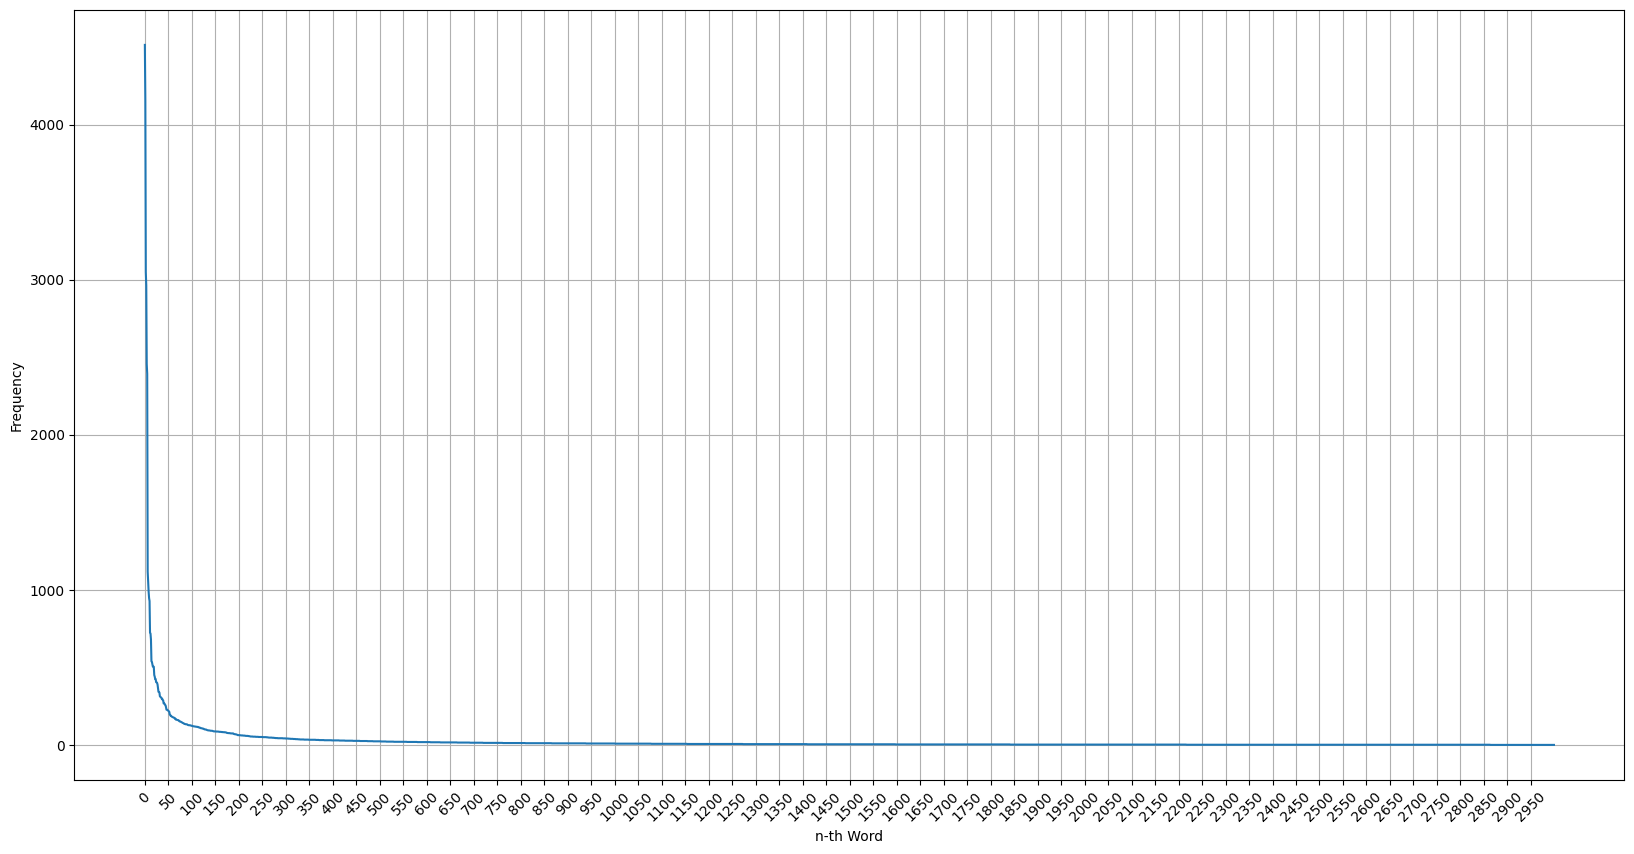

In [17]:
#plot the words vs frequency graph 
lower_limit=0 
upper_limit=3000 
difference_between_each_xtick=50  #default value. change these values to observe the graph in more depth
#adjusting size of the graph for more clearity.
plt.figure(figsize=(20, 10))
#plotting
plt.plot(np.arange(upper_limit), freq_words[lower_limit:upper_limit])
plt.xlabel('n-th Word') # x axis represents word so n-th word represt most occuring n-th word
plt.ylabel("Frequency") # y axis represent the frequency corresponding to these words
#adjusting the xticks
plt.xticks(np.arange(lower_limit, upper_limit, 50), rotation=45)
plt.grid()
plt.show()

In [18]:
freq_words[1000]
# the words exponentially decrease and after say 1000th word, words seems to present in less than 10 tweets and so

11

<span style="font-size: 20px; font-weight:light">From the above graph it is evident that the count of words exponentialy decreases so it doesn't matter to consider those words which roughly present in few documents</span>  
<span style="font-size: 20px; font-weight:light">For the training purpose it's better to take more frequently words excluding the stopping words as it will have more effect on deciding whhich label to choose</span>  

In [19]:
word_features = unique_words[0:10000].tolist()

In [20]:
# the fucntion converts the given document to an array of length (word_features)
# and each index corresponds to each feature word values how much it contains in the document
def document_to_array(document,word_features):
    modified_document =np.zeros(len(word_features))
    for word in document:
        if word in word_features:
            index = word_features.index(word)
            modified_document[index]=modified_document[index]+1
    return modified_document    

In [21]:
def get_modified_data(data,word_features):
    modified_data=[]
    for document in data:
        modified_data.append(document_to_array(document,word_features))
    return modified_data

In [22]:
X_train_modified = get_modified_data(X_train,word_features)
X_eval_modified = get_modified_data(X_eval,word_features)

<span style="font-size: 25px; font-weight:bold">Multinomial Naive Bayes From Sklearn</span>

In [23]:
model1 = MultinomialNB(alpha=1)
model1.fit(X_train_modified, Y_train)

MultinomialNB(alpha=1)

In [24]:
Y_pred1 = model1.predict(X_eval_modified)

In [25]:
accuracy = metrics.accuracy_score(Y_eval, Y_pred1)
accuracy

0.6754098360655738

<span style="font-size: 25px; font-weight:bold">Feature Extraction Using Count Vectorizer</span>

In [26]:
len(X_train_tweets),len(X_eval_tweets)

(10980, 3660)

In [27]:
len(Y_train), len(Y_eval)

(10980, 3660)

In [28]:
model2 = MultinomialNB(alpha=2)

In [29]:
count_vec = CountVectorizer(max_features = 10000 , ngram_range=(1,3)) 

In [30]:
X_train_cv = count_vec.fit_transform(X_train_tweets) 
X_eval_cv = count_vec.transform(X_eval_tweets) 

In [31]:
model2.fit(X_train_cv,Y_train)

MultinomialNB(alpha=2)

In [32]:
Y_pred2 = model2.predict(X_eval_cv)

In [33]:
accuracy = metrics.accuracy_score(Y_eval, Y_pred2)
accuracy

0.7852459016393443

<span style="font-size: 25px; font-weight:bold">Support Vector Machine</span>

In [34]:
from sklearn import svm

In [56]:
model3 = svm.SVC(kernel='linear',C=100000)

In [57]:
model3.fit(X_train_cv,Y_train)

SVC(C=100000, kernel='linear')

In [58]:
Y_pred3 = model3.predict(X_eval_cv)

In [59]:
accuracy = metrics.accuracy_score(Y_eval, Y_pred3)
accuracy

0.7497267759562841